### Modelo De impulso Nervioso de Hodgkin-Huxley 

El modelo de Hogkin - Huxley describe el comportamiento de las neuronas, suponiendo que la membrana celular posee canales los cuales permiten el paso de iones de $Na^{+}$ y $K^{+}$, cuyo movimiento genera corrientes eléctricas que producen los cambios de potencial de acción.  

La descripción se realiza por medio de un sistema no lineal de ecuaciones diferenciales ordinarias, el cual se muestra a continuación,

$$C\frac{dV}{dt} = -g_{K}n^{4}(V-V_{k}) - g_{Na}m^{3}h(V-V_{Na}) - g_{L}(V-V_{L}) + I_{ext}(t)$$

$$\frac{dn}{dt} = \alpha_{n}(1-n) - \beta_{n}n$$

$$\frac{dm}{dt} = \alpha_{m}(1-m) - \beta_{m}m$$

$$\frac{dh}{dt} = \alpha_{h}(1-h) - \beta_{h}h$$

Donde $C$ es la capacitancia de la membrana, $V$ es el potencial de la membrana, $g_{K}$ y $g_{Na}$ son constantes que determinan la conductancia de los iones de potasio y sodios, respectivamente; $n$ representa la dinámica de los canales por los cuales circulan los iones de potasio, mientras que $m$ y $h$ representan la dinámica de los canales por los cuales circulan los iones de sodio; $V_{K}$ y $V_{Na}$ son los potenciales de equilibrio para los cuales no hay corriente neta de potasio y sodio, respectivamente; $g_{L}$ es una constante que determina la conductancia de una pequeña corriente de escape compuesta principalmente por iones de cloro, mientras que $V_{L}$ es el potencial de equilibrio para dicha corriente de escape. 

Finalmente, $I_{ext}(t)$ representa los pulsos de corriente que pueden generar potenciales de acción, mientras que $\alpha_{i}$ y $\beta_{i}$ son constantes de proporción dependientes del voltaje, las cuales describen las razones de transición de los estados "no permisivo a permisivo" y "permisivo a no permisivo", respectivamente

Hodgkin y Huxley encontraron dichas constantes de proporción. Para el caso de las constantes que gobiernan las variables de activación e inactivación del potasio, se tiene:

$$\alpha_{n} = \frac{10 - (V - V_{r})}{100[e^{\left(1 - \frac{(V - V_{r})}{10}\right)} - 1]}$$

$$\beta_{n} = 0.125e^{-\frac{(V - V_{r})}{80}}$$

Mientras que para el sodio,

$$\alpha_{m} = \frac{25 - (V - V_{r})}{100[e^{\left(2.5 - \frac{(V-V_{r})}{10}\right)}-1]}$$

$$\beta_{m} = 4e^{-\frac{(V-V_r)}{18}}$$

$$\alpha_{h} = 0.07e^{-\frac{(V - V_{r})}{20}}$$

$$\beta_{h} = \frac{1}{e^{\left(3 - \frac{(V - V_{r})}{10}\right)} + 1}$$

Donde $V_{r}$ es el potencial en reposo, que por lo general es de $-70mV$.

In [1]:
### LIBRERIAS IMPORTANTES PARA LA DESCRIPCIÓN NÚMERICA DE LAS NEURONAS ###
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ipywidgets import interact
import matplotlib.pyplot as plt
import seaborn as sns
from numba import jit
import scipy
from scipy.fftpack import rfft, fftfreq
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set_context("poster")

A continuación se definen las funciones $\alpha_{i}$, $\beta_{i}$ y el sistema de ecuaciones diferenciales.

In [2]:
#Gates
#Vr=-70
def alfn(V, Vr):
  "alpha_n"
  return 0.01*(10-(V-Vr))/(np.exp(1-(V-Vr)/10)-1)
def betn(V, Vr):
  "betha_n"
  return 0.125*np.exp(-(V-Vr)/80)
def alfm(V, Vr):
  "alpha_m"
  return 0.1*(-(V-Vr)+25)/(np.exp(2.5-(V-Vr)/10)-1)
def betm(V, Vr):
  "betha_m"
  return 4*np.exp(-(V-Vr)/18)
def alfh(V, Vr):
  "alpha_h"
  return 0.07*np.exp(-(V-Vr)/20)
def beth(V, Vr):
  "betha_h"
  return 1/(np.exp(3-(V-Vr)/10)+1)
#corriente base
# def Iext(t):
#   return 0
#equation system
def fderiv(t, y, C, gk, Vk, gNa, VNa, gL, VL, Vr, Iext, iex):  ##ES NECESARIO iex PARA REALIZAR LAS GRAFICAS INTERACTIVAS
  '''Función que define el sistema de ecuaciones: y[0] = V, y[1] = n, y[2] = m, y[3] = h'''
  def Iexttrue(t, iex):
    return Iext(t, iex)
  return np.array([1/C*(-gk*np.power(y[1],4)*(y[0]-Vk)-gNa*np.power(y[2],3)*y[3]*(y[0]-VNa)-gL*(y[0]-VL)+Iexttrue(t, iex)),
                    (alfn(y[0], Vr)*(1-y[1])-betn(y[0], Vr)*y[1]),
                    (alfm(y[0], Vr)*(1-y[2])-betm(y[0], Vr)*y[2]),
                    (alfh(y[0], Vr)*(1-y[3])-beth(y[0], Vr)*y[3])])

A continuación se estudia el estado estacionario, para lo cual $\dot{n} = \dot{m} = \dot{h} = 0$ y por tanto,

$$n = \frac{\alpha_n}{\alpha_n + \beta_n}$$

$$m = \frac{\alpha_m}{\alpha_m + \beta_m}$$

$$h = \frac{\alpha_h}{\alpha_h + \beta_h}$$

In [90]:
#Steady State
#a)
def graficar(Vr = -70):
  V = np.linspace(-100,100,200)

  n = alfn(V, Vr)/(alfn(V, Vr)+ betn(V, Vr))
  m = alfm(V, Vr)/(alfm(V, Vr)+ betm(V, Vr))
  h = alfh(V, Vr)/(alfh(V, Vr)+ beth(V, Vr))


  plt.figure(figsize=(14,6))
  plt.plot(V, n,label=r"n")
  plt.plot(V, m,label=r"m")
  plt.plot(V, h,label=r"h")
  plt.xlabel(r"$V$[mV]")
  plt.ylabel(r"Proportion Open Gates")
  plt.title("n(V), m(V) y h(V)",fontweight="bold")
  plt.legend()
    
interact(graficar, Vr=(-100,60))

interactive(children=(IntSlider(value=-70, description='Vr', max=60, min=-100), Output()), _dom_classes=('widg…

<function __main__.graficar(Vr=-70)>

Estudiando el caso general, en el cual $V$, $n$, $m$ y $h$ cambian con el tiempo, se procede a resolver numéricamente el sistema de ecuaciones diferenciales.

Para esto, se tiene

$C = 1.0\frac{\mu F}{cm^{2}}$

$g_{k} = 24.34\frac{mS}{cm^{2}}$

$V_{k} = -82mV$

$g_{Na} = 70.7\frac{mS}{cm^2}$

$V_{Na} = 55mV$

$g_L = 0.3\frac{mS}{cm^2}$

$V_L = -59mV$

Además, se utilizaron las siguientes condiciones iniciales:

$V_0 = -70mV$, $n_0 = 0.315$, $m_0 = 0.042$, $h_0 = 0.608$.

In [4]:
                      #Caso General 
# b)
 ## SE DEFINEN LAS CONSTANTES Y CONDICIONES INICIALES ##
C = 1.0
gK = 24.34
VK = -82
gNa = 70.7
VNa = 55
gL = 0.3
VL = -59

V0 = -70
n0 = 0.315
m0 = 0.042
h0 = 0.608

def general(iex = 5.4):

  def Iext(t,iex):
    "funcion arbritraria de corrientes externas que afecten el impulso nervioso"
    if (t>=0 and t<1) or t>2:
      return 0
    else:
      return iex
  
  x = np.linspace(0,20,50)
  Iex = []
  for i in x:
    Iex.append(Iext(i,iex))

  T0=0
  TF=40
  DT=0.1

  sol = solve_ivp(fderiv, t_span = [T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0 = [V0, n0, m0, h0], args = (C, gK, VK, gNa, VNa, gL, VL, V0, Iext, iex))

  fig,ax = plt.subplots(3,1,figsize=(14,33))

  ## SE GRAFICA LA CORRIENTE EXTERNA INDUCIDA ##
  ax[0].plot(x,Iex)
  ax[0].set_xlabel("Tiempo [ms]")
  ax[0].set_ylabel("Corriente Externa [μA]")
  ax[0].set_title("Corriente Externa Inducida",fontsize=30,fontweight="bold")

  ## SE GRAFICA EL COMPORTAMIENTO DE LAS COMPUERTAS ##
  ax[1].plot(sol.t, sol.y[1], label=r"n")
  ax[1].plot(sol.t, sol.y[2], label=r"m")
  ax[1].plot(sol.t, sol.y[3], label=r"h")
  ax[1].set_xlabel(r"$t$[ms]")
  ax[1].set_ylabel(r"Proportion of Open Gates")
  ax[1].set_title("Caso No Steady-State",fontsize=30,fontweight="bold")
  ax[1].legend()

  ## SE GRAFICA EL COMPORTAMIENTO DEL POTENCIAL ##
  ax[2].plot(sol.t, sol.y[0], label=f"Con Pulso de Corriente = {iex} [μA]")
  ax[2].set_xlabel("Tiempo [ms]")
  ax[2].set_ylabel("V[mV]")
  ax[2].set_title("Potencial de la membrana",fontsize=30,fontweight="bold")
  ax[2].legend()


interact(general, iex=(0,6,0.2))

interactive(children=(FloatSlider(value=5.4, description='iex', max=6.0, step=0.2), Output()), _dom_classes=('…

<function __main__.general(iex=5.4)>

A continuación se estudia el comportamiento del potencial para diferentes corrientes con el fin de ver para que corriente se tienen picos puntiagudos en las graficas.

In [92]:
#Punto c
def grapher(iex=5):
  def Iext(t, iex):
    "funcion arbritraria de corrientes externas que afecten el impulso nervioso"
    if (t>=0 and t<1) or t>2:
      return 0
    else:
      return iex
  
  T0=0
  TF=40
  DT=0.1

  fig, ax = plt.subplots(figsize=(14,8))
  d = iex-0.2
  e = d-0.2
  sol1 = solve_ivp(fderiv, t_span = [T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0 = [V0, n0, m0, h0], args = (C, gK, VK, gNa, VNa, gL, VL, V0, Iext, iex))
  sol2 = solve_ivp(fderiv, t_span = [T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0 = [V0, n0, m0, h0], args = (C, gK, VK, gNa, VNa, gL, VL, V0, Iext, d))
  sol3 = solve_ivp(fderiv, t_span = [T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0 = [V0, n0, m0, h0], args = (C, gK, VK, gNa, VNa, gL, VL, V0, Iext, e))
  ax.plot(sol1.t, sol1.y[0], label=f"I = {np.round(iex,decimals=2)} [μA]")
  ax.plot(sol2.t, sol2.y[0], label=f"I = {np.round(d,decimals=2)} [μA]")
  ax.plot(sol3.t, sol3.y[0], label=f"I = {np.round(e,decimals=2)}[μA]")
  ax.set_ylabel(f"$V\:[mV]$")
  ax.set_xlabel(f"$t\:[ms]$")
  ax.legend()

interact(grapher, iex= (-2,10,0.1)) # COMIENZAN A HABER PICOS DESDE I_EXT = 5.4 ###

interactive(children=(FloatSlider(value=5.0, description='iex', max=10.0, min=-2.0), Output()), _dom_classes=(…

<function __main__.grapher(iex=5)>

A continuación se estudia le relción entre la corriente externa y los trenes de picos de potencial que se obtienen.

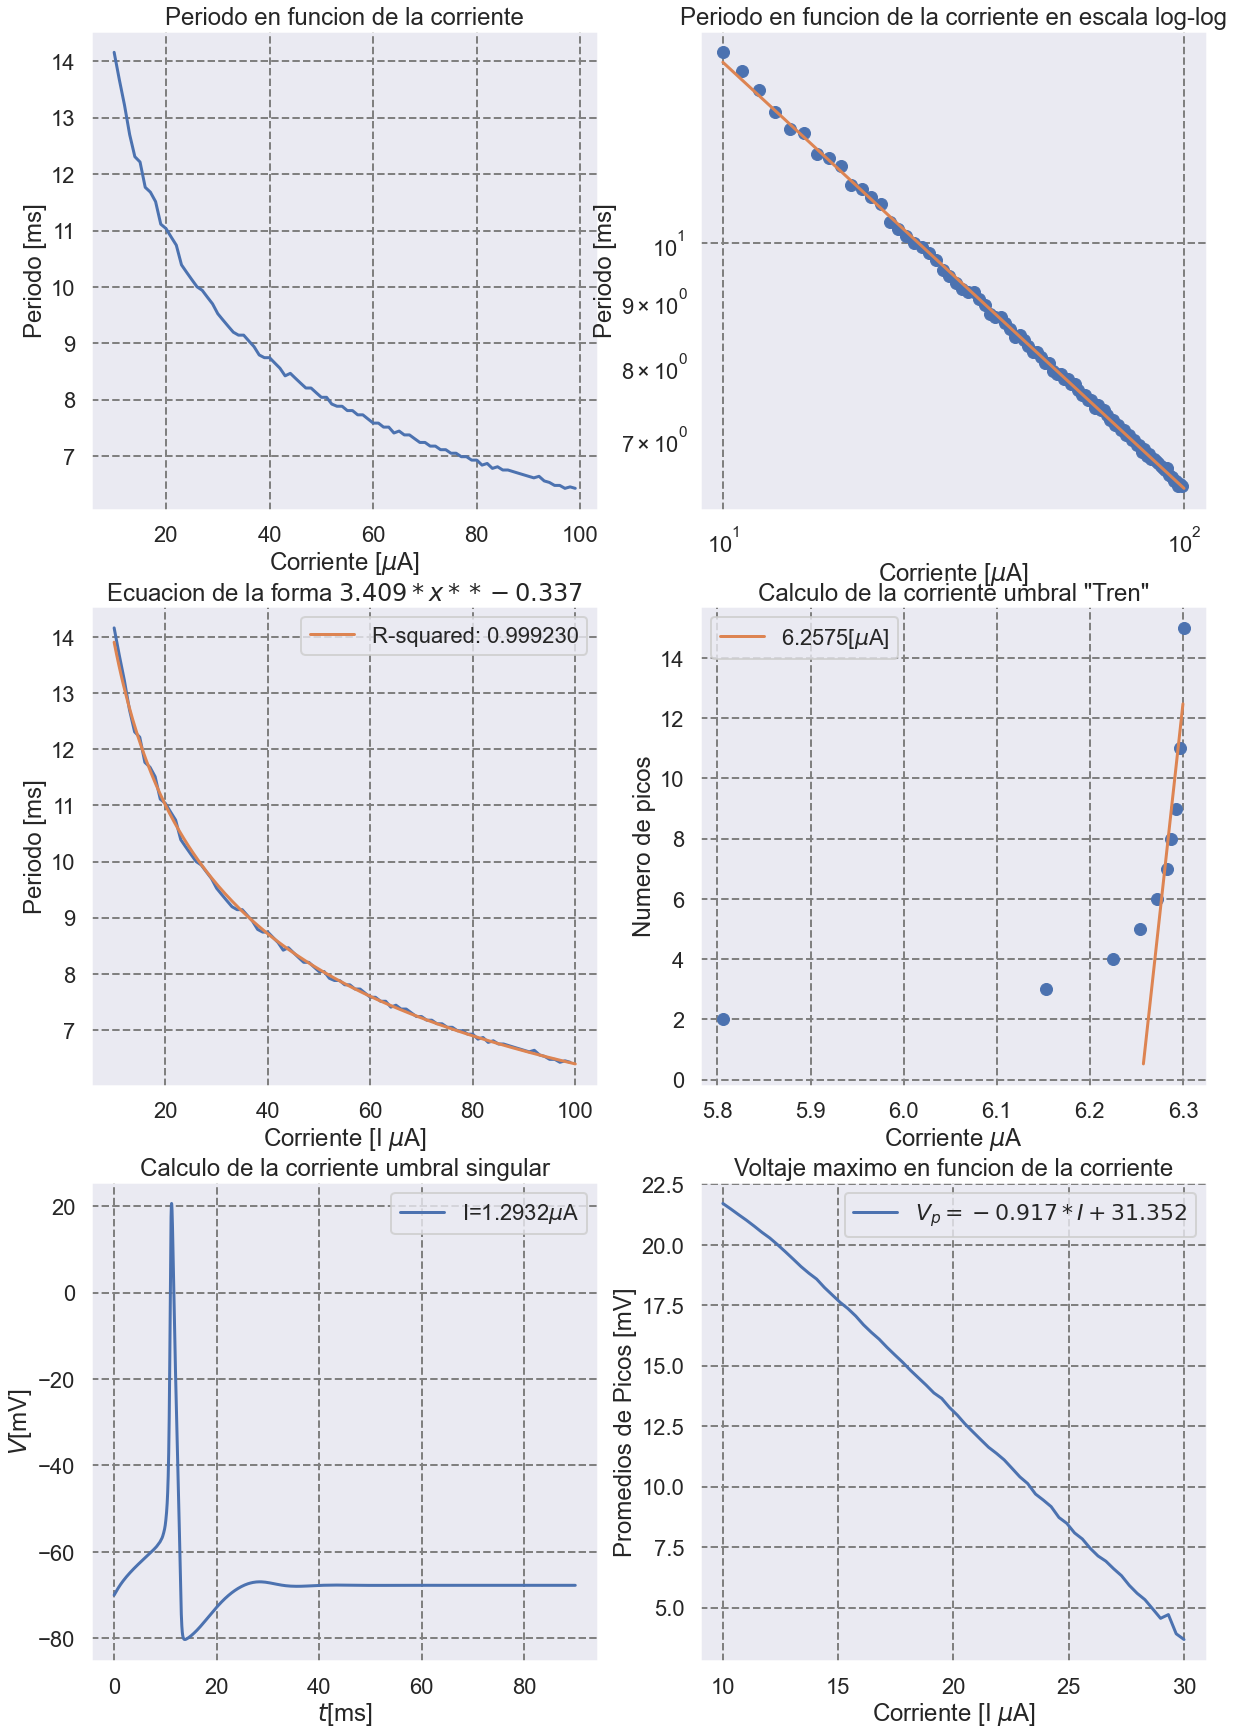

In [6]:
#D
def puntod():
  "Constantes usadas (el intervalo de tiempo puede variar a conveniencia)"

  T0=0
  TF=40
  DT=0.1

  #funcion que calcula los maximos de una funcion y los retorna junto con sus ubicaciones 
  def nmaximos(x,y,aumento,grafica):
    '''Retorna ubicaciones y maximos'''
    maximos=[]
    ubicaciones=[]
    indexmax=np.where(np.abs(y) == np.max(np.abs(y))) #donde esta el maximo de una funcion
    j=0
    maxtemporal=np.max(y[int(j):])+1
    while True:
      
      if any(y[int(j):]) and j<len(y) : 
        maxtemporal=np.max(y[int(j):])
        indexmax=np.where(np.abs(y) == maxtemporal)[0]#donde esta el maximo temporal
        if len(indexmax)>0 and  len(indexmax)!=2 :
          ubicaciones.append(x[indexmax[0]])
          maximos.append(maxtemporal)
          j=indexmax+aumento
        j+=aumento
      else: break

    if grafica==1:
      #Grafica
      fig, ax = plt.subplots(figsize=(8,8))
      ax.plot(x,y,".-")
      ax.plot(ubicaciones,maximos,".")

    return ubicaciones, maximos
  
  #funcion que calcula la transformada de Fourier y devulve frecuencia y periodo

  def Fourier(x,y,grafica,picos=2):
    dt = x[1] - x[0]
    yf = scipy.fftpack.rfft(y-np.mean(y))
    xf = scipy.fftpack.fftfreq(yf.size,dt)
    yf=np.abs(yf)
    copia=np.sort(yf)[::-1]
    ubi=np.ones(3)
    maxi=np.ones(3)
    for i in range(3):
      lugar=np.where(copia[i]==yf)[0]
      ubi[i]=xf[lugar]
      maxi[i]=yf[int(lugar)]

    indexmax=np.where(np.abs(yf) == np.max(np.abs(yf)))
    
    if grafica==1:
      #graficas
      fig, ax = plt.subplots(1,2,figsize=(18,8))
      ax[0].plot(x,y)
      ax[0].grid(axis = 'both', color = 'gray', linestyle = 'dashed')

      ax[1].plot(xf[:x.size//2], yf[:yf.size//2],".-")
      ax[1].plot(ubi,maxi,"o")
      ax[1].set_xlim([0, 1])
      ax[1].grid(axis = 'both', color = 'gray', linestyle = 'dashed')
    ubi=np.sort(ubi)
    return ubi[0],2/ubi[0]
  
  #Funcion que calcula la derivada central
  def central(f, x, h=10**(-5)):
    if type(f)==type(np.array([])):
      df=np.ones(f.size)
      dt=x[1]-x[0]
      df[1:f.size-1]=(-f[:f.size-2]+f[2:])/(2*dt)
      return df[1:f.size-1]
    
    return (f(x+h/2)-f(x-h/2))/h
  
  #funcion que calcula el valor promedio de los picos de una funcion
  def prompicos(x,y,grafica):
    rango=np.where(np.isclose(df, 0, rtol=0.3, atol=0.3))
    picos=[]
    npicos=[]
    for i in rango[0]:
      if sol.y[0][i]>0:
        picos.append(sol.y[0][i])
        npicos.append(sol.t[i])


    if grafica==1:
      fig,ax=plt.subplots(1,2,figsize=(18,8))
      ax[0].plot(sol.t[1:-1],df,".")
      ax[0].plot(sol.t,sol.y[0])

      ax[0].grid(axis = 'both', color = 'gray', linestyle = 'dashed')
      ax[1].plot(sol.t,sol.y[0])
      ax[1].plot(npicos,picos,".")
      ax[1].grid(axis = 'both', color = 'gray', linestyle = 'dashed')
      ax[1].plot(npicos,np.ones(len(npicos))*np.mean(picos[3:]))
    
    return np.mean(picos[3:])

  #Corriente umbral
  TF=400
  DT=0.1
  j=2
  ii=5.78
  npicos=[]
  corrientes=[]
  while j<15:
    for i in np.linspace(ii,6.4,25):
      def Iext(t, i):
          return i
      sol = solve_ivp(fderiv, t_span=[T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0=[V0, n0, m0, h0 ],
                      args=(C, gK, VK, gNa, VNa, gL, VL, V0, Iext, i))
      picos=nmaximos(sol.t,sol.y[0],80,0)
      if len(picos[1])>=j:
        npicos.append(i)
        corrientes.append(len(picos[1]))
        ii=i
        j=len(picos[1])+1
        break
  #relacion funcional 
  y = corrientes[4:]
  x = npicos[4:]
  CUres = stats.linregress(x, y)
  CUejex=np.linspace(6.2575,6.3,25)
  CUejey=CUres.intercept+CUejex*CUres.slope

  #determinacion de Frecuencia y periodo en funcion de la corriente y su realcion funcional
  TF=800
  DT=0.1
  frec=[]
  peri=[]
  
  rango=range(10,100)
  for i in rango:
    def Iext(t, i):
      return i
      print(i)
    sol = solve_ivp(fderiv, t_span=[T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0=[V0, n0, m0, h0 ],
                    args=(C, gK, VK, gNa, VNa, gL, VL, V0, Iext, i))
    Frecuencia,Periodo=Fourier(sol.t,sol.y[0],0)
    frec.append(Frecuencia)
    peri.append(Periodo)
  
  #relacion funcional 
  x = np.log(rango)
  y = np.log(peri)
  res = stats.linregress(x, y)
  ejex=np.linspace(10,100,200)
  ejey=np.exp(res.intercept)*np.power(ejex,res.slope)
  
  #corriente umbral para un unico pico significativo (mayor que 0)
  pico=-1
  TF=40
  DT=0.01
  for i in np.linspace(1,1.35,500):
    def Iext(t, i):
      return i
    sol = solve_ivp(fderiv, t_span=[T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0=[V0, n0, m0, h0 ],
                  args=(C, gK, VK, gNa, VNa, gL, VL, V0, Iext, i))
    pico=np.max(sol.y[0])

    if pico>0:
      TF=90
      sol = solve_ivp(fderiv, t_span=[T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0=[V0, n0, m0, h0 ],
                    args=(C, gK, VK, gNa, VNa, gL, VL, V0, Iext, i))
      singularx=sol.t
      singulary=sol.y[0]
      umbralsingular=i
      break
        
    i-=0.1
  
  #cota superior de los picos en funcion de la corriente
  promA=[]
  TF=80
  DT=0.001
  for i in np.linspace(10,30,60):
    def Iext(t, i):
      return i
    sol = solve_ivp(fderiv, t_span=[T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0=[V0, n0, m0, h0 ],
                  args=(C, gK, VK, gNa, VNa, gL, VL, V0, Iext, i))
    y=sol.y[0]
    df=central(y, sol.t, h=10**(-5))
    promA.append(prompicos(sol.t,df,0))
  #relacion funcional
  x = np.linspace(10,30,60)
  y = promA
  Ares = stats.linregress(x, y)

  #graficas
  fig,ax=plt.subplots(3,2,figsize=(20,30))

  ax[0][0].plot(rango,peri)
  ax[0][0].set_xlabel(f'Corriente [$\mu$A]')
  ax[0][0].set_ylabel(f'Periodo [ms]') 
  ax[0][0].grid(axis = 'both', color = 'gray', linestyle = 'dashed')
  ax[0][0].set_title(f'Periodo en funcion de la corriente')

  ax[0][1].plot(rango,peri,"o")
  ax[0][1].plot(ejex,ejey)
  ax[0][1].set_xlabel(f'Corriente [$\mu$A]')
  ax[0][1].set_ylabel(f'Periodo [ms]') 
  ax[0][1].grid(axis = 'both', color = 'gray', linestyle = 'dashed')
  ax[0][1].set_xscale('log')
  ax[0][1].set_yscale('log')
  ax[0][1].set_title(f'Periodo en funcion de la corriente en escala log-log')

  ax[1][0].plot(rango,peri)
  ax[1][0].plot(ejex,ejey,label=f"R-squared: {res.rvalue**2:.6f}")
  ax[1][0].set_xlabel(f'Corriente [I $\mu$A]')
  ax[1][0].set_ylabel(f'Periodo [ms]') 
  ax[1][0].grid(axis = 'both', color = 'gray', linestyle = 'dashed')
  ax[1][0].set_title(f'Ecuacion de la forma ${res.intercept:.3f}*x**{res.slope:.3f}$')
  ax[1][0].legend()

  ax[1][1].plot(npicos,corrientes,"o")
  ax[1][1].set_xlabel(f"Corriente $\mu$A")
  ax[1][1].set_ylabel(f"Numero de picos")
  ax[1][1].set_title('Calculo de la corriente umbral "Tren"')
  ax[1][1].grid(axis = 'both', color = 'gray', linestyle = 'dashed')
  ax[1][1].plot(CUejex,CUejey,label=f"6.2575[$\mu$A]")
  ax[1][1].legend()

  ax[2][0].plot(singularx, singulary, label=f"I={umbralsingular:.4f}$\mu$A")
  ax[2][0].set_ylabel(r"$V$[mV]")
  ax[2][0].set_xlabel(r"$t$[ms]")
  ax[2][0].set_title('Calculo de la corriente umbral singular')
  ax[2][0].grid(axis = 'both', color = 'gray', linestyle = 'dashed')
  ax[2][0].legend()

  ax[2][1].plot(np.linspace(10,30,60),promA, label=f"$V_{'p'}={Ares.slope:.3f}*I+{Ares.intercept:.3f}$")
  ax[2][1].set_xlabel(f'Corriente [I $\mu$A]')
  ax[2][1].set_ylabel(f'Promedios de Picos [mV]') 
  ax[2][1].grid(axis = 'both', color = 'gray', linestyle = 'dashed')
  ax[2][1].set_title('Voltaje maximo en funcion de la corriente')
  ax[2][1].legend()

puntod()

Ahora, se estudia el comportamiento de potencial para distintos saltos de los pulsos de corriente.

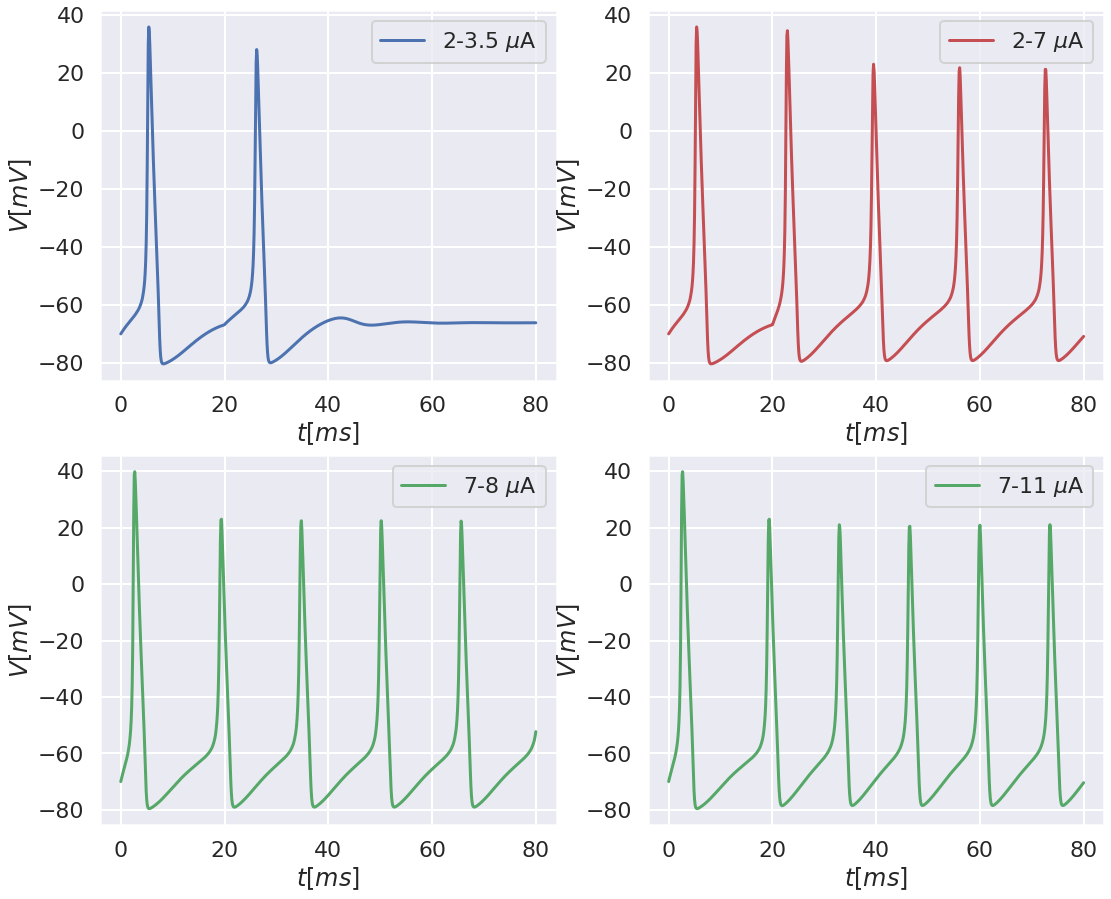

In [93]:
# Punto E, saltos de Corriente
def d1Iext(t, iex):
  if  t<20:
    return iex
  else:
    return iex + 1.5
def d2Iext(t, iex):
  if  t<20:
    return iex
  else:
    return iex + 5
def d3Iext(t, iex):
  if  t<20:
    return iex
  else:
    return iex + 1
def d4Iext(t, iex):
  if  t<20:
    return iex
  else:
    return iex + 4

T0=0
TF=80
DT=0.1

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,15))
figsize=(10,8)
sol1 = solve_ivp(fderiv, t_span = [T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0 = [V0, n0, m0, h0], args = (C, gK, VK, gNa, VNa, gL, VL, V0, d1Iext, 2))
sol2 = solve_ivp(fderiv, t_span = [T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0 = [V0, n0, m0, h0], args = (C, gK, VK, gNa, VNa, gL, VL, V0, d2Iext, 2))
sol3 = solve_ivp(fderiv, t_span = [T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0 = [V0, n0, m0, h0], args = (C, gK, VK, gNa, VNa, gL, VL, V0, d3Iext, 7))
sol4 = solve_ivp(fderiv, t_span = [T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0 = [V0, n0, m0, h0], args = (C, gK, VK, gNa, VNa, gL, VL, V0, d4Iext, 7))
ax1.plot(sol1.t, sol1.y[0],"b",label=r"2-3.5 $\mu$A")
ax2.plot(sol2.t, sol2.y[0],"r",label=r"2-7 $\mu$A")
ax3.plot(sol3.t, sol3.y[0],"g",label=r"7-8 $\mu$A")
ax4.plot(sol4.t, sol4.y[0],"g",label=r"7-11 $\mu$A")
ax1.set_ylabel("$V[mV]$")
ax1.set_xlabel("$t[ms]$")
ax2.set_ylabel("$V[mV]$")
ax2.set_xlabel("$t[ms]$")
ax3.set_ylabel("$V[mV]$")
ax3.set_xlabel("$t[ms]$")
ax4.set_ylabel("$V[mV]$")
ax4.set_xlabel("$t[ms]$")
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

A continuación se ve el comportmiento del potencial para pulsos de corriente de la misma apmlitud pero intermitentes.

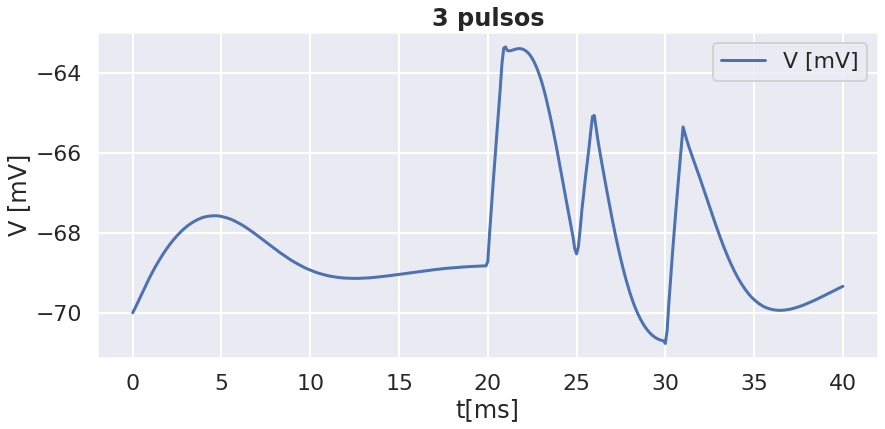

In [94]:
#PUNTO F - pulsos
iex = 7
def Iextf(t, iex):
  "funcion de pulsos de corriente"
  if (t>=20 and t<=21) or (t>=25 and t<=26) or (t>=30 and t<=31):
    return iex
  else:
    return 0

T0=0
TF=40
DT=0.1

sol = solve_ivp(fderiv, t_span = [T0, TF], t_eval=np.arange(T0, TF+DT, DT), y0 = [V0, n0, m0, h0], args = (C, gK, VK, gNa, VNa, gL, VL, V0, Iextf, iex))

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(sol.t, sol.y[0], label=r"V [mV]")
plt.xlabel('t[ms]')
plt.ylabel('V [mV]')
plt.title("3 pulsos",fontweight="bold")
plt.legend()